## 1. Time Series Classification Part 1: Feature Creation/Extraction

### (a) Download Data

Package imports

In [1]:
# pip install bootstrapped

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import bootstrap
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [3]:
def warn(*args, **kwargs):  # Hiding the red warnings from sklearn and pandas for a better-looking output
    pass
import warnings
warnings.warn = warn  # Reference: https://stackoverflow.com/questions/32612180/eliminating-warnings-from-scikit-learn

Get the AReM Data Set

### (b) Test and Train Data

Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1,
2, and 3 in other folders as test data and other datasets as train data.

In [4]:
# 1.b 
# Keep datasets 1 and 2 in folders bending1 and bending 2 as well as datasets 1, 2, and 3 in other folders as test data
test_df_list = []
bend_index = [1,2]
folder_names = ['bending1', 'bending2']
for folder in folder_names:
    for i in bend_index:
        file_name = f'../data/AReM/{folder}/dataset{i}.csv'
        test_df_temp = (pd.read_csv(file_name, skiprows = 4, usecols=range(7))).rename(columns={"# Columns: time": "time"})
        test_df_temp['activity'] = f'{folder}'
        test_df_list.append(test_df_temp)
#test_df_list
#print(len(test_df_list))

test_index = [1 ,2 ,3]
folder_names = ['cycling', 'lying', 'sitting', 'standing', 'walking']
for folder in folder_names:
    for i in test_index:
        file_name = f'../data/AReM/{folder}/dataset{i}.csv'
        test_df_temp = (pd.read_csv(file_name, skiprows = 4, usecols=range(7))).rename(columns={"# Columns: time": "time"})
        test_df_temp['activity'] = f'{folder}'
        test_df_list.append(test_df_temp)
#test_df_list
test_df = pd.concat(test_df_list)
test_df

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,activity
0,0,39.25,0.43,22.75,0.43,33.75,1.30,bending1
1,250,39.25,0.43,23.00,0.00,33.00,0.00,bending1
2,500,39.25,0.43,23.25,0.43,33.00,0.00,bending1
3,750,39.50,0.50,23.00,0.71,33.00,0.00,bending1
4,1000,39.50,0.50,24.00,0.00,33.00,0.00,bending1
...,...,...,...,...,...,...,...,...
475,118750,36.00,2.45,17.00,5.10,20.50,0.87,walking
476,119000,34.33,1.89,15.00,2.45,17.00,2.12,walking
477,119250,33.00,7.35,14.60,3.14,13.00,5.70,walking
478,119500,31.67,1.25,11.00,6.16,19.25,2.17,walking


In [5]:
# Other datasets as train data.
train_df_list = []
folder_names = ['bending1', 'bending2']
for folder in folder_names:
    folder_path = f'../data/AReM/{folder}'
    num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]) # Assisted by ChatGPT with OS package
    for i in np.arange(3, num_files+1):
        file_name = f'../data/AReM/{folder}/dataset{i}.csv'
        train_df_temp = (pd.read_csv(file_name, skiprows = 4, usecols=range(7))).rename(columns={"# Columns: time": "time"})
        train_df_temp['activity'] = f'{folder}'
        train_df_list.append(train_df_temp)

folder_names = ['cycling', 'lying', 'sitting', 'standing', 'walking']
for folder in folder_names:
    folder_path = f'../data/AReM/{folder}'
    num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    for i in np.arange(4, num_files+1):
        file_name = f'../data/AReM/{folder}/dataset{i}.csv'
        train_df_temp = (pd.read_csv(file_name, skiprows = 4, usecols=range(7))).rename(columns={"# Columns: time": "time"})
        train_df_temp['activity'] = f'{folder}'
        train_df_list.append(train_df_temp)

train_df = pd.concat(train_df_list)
train_df

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,activity
0,0,42.00,0.71,21.25,0.43,30.00,0.00,bending1
1,250,41.50,0.50,20.25,1.48,31.25,1.09,bending1
2,500,41.50,0.50,14.25,1.92,33.00,0.00,bending1
3,750,40.75,0.83,15.75,0.43,33.00,0.00,bending1
4,1000,40.00,0.71,20.00,2.74,32.75,0.43,bending1
...,...,...,...,...,...,...,...,...
475,118750,34.50,6.18,9.00,3.56,12.67,4.19,walking
476,119000,25.75,6.02,13.75,2.05,16.00,1.58,walking
477,119250,31.50,3.35,10.25,5.12,16.25,2.95,walking
478,119500,33.75,2.77,14.00,3.24,13.75,0.43,walking


### (c) Feature Extraction

Classification of time series usually needs extracting features from them. In this
problem, we focus on time-domain features.

#### i. Research

i. Research what types of time-domain features are usually used in time series
classification and list them (examples are minimum, maximum, mean, etc).

    (Reference: https://stats.stackexchange.com/questions/50807/features-for-time-series-classification)

    Basic statistical features: Mean, vairance, standard deviation, minimum, maximum, median, range, median, skewness (asymmetry of the distribution), kurtosis (tailedness of distribution); 
    Time-series related features: dxd cross-correlation (between two time series at different lags), autocorrelation (correlation with a lagged version of itself), lagged values (values at specific time lags)
    Others: Peak count (number of peaks in time series), slope of trend (slope of the fitted linear trend line)

#### ii. Extraction

Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series
in each instance. You are free to normalize/standardize features or use them
directly.

In [6]:
df_list = train_df_list + test_df_list
result_list = []
for i in np.arange(len(df_list)):  # Instances
    row_i_list = []
    for col in [1,2,3,4,5,6]:  # Column headers
        cell = pd.DataFrame({
            #'Instance': [i+1],
            f'min_{col}': [np.min(df_list[i].iloc[:,col])],
            f'max_{col}': [np.max(df_list[i].iloc[:,col])],
            f'mean_{col}': [np.mean(df_list[i].iloc[:,col])],
            f'median_{col}': [np.median(df_list[i].iloc[:,col])],
            f'std_{col}': [np.std(df_list[i].iloc[:,col])],
            f'1st_quant_{col}': [np.quantile((df_list[i].iloc[:,col]), 0.25)],
            f'3rd_quant_{col}': [np.quantile((df_list[i].iloc[:,col]), 0.75)]
        })
        row_i_list.append(cell)
    row_i = pd.concat(row_i_list, axis = 1)
    result_list.append(row_i)
time_domain_features = pd.concat(result_list)

Instance = np.arange(1, len(df_list)+1)
time_domain_features.index = Instance
time_domain_features

,min_1,max_1,mean_1,median_1,std_1,1st_quant_1,3rd_quant_1,min_2,max_2,mean_2,...,std_5,1st_quant_5,3rd_quant_5,min_6,max_6,mean_6,median_6,std_6,1st_quant_6,3rd_quant_6
1,35.00,47.40,43.954500,44.330,1.557210,43.00,45.0000,0.0,1.70,0.426250,...,1.997520,35.3625,36.500,0.0,1.79,0.493292,0.430,0.512971,0.000,0.940
2,33.00,47.75,42.179812,43.500,3.666840,39.15,45.0000,0.0,3.00,0.696042,...,3.845436,30.4575,36.330,0.0,2.18,0.613521,0.500,0.523771,0.000,1.000
3,33.00,45.75,41.678063,41.750,2.241152,41.33,42.7500,0.0,2.83,0.535979,...,2.408514,28.4575,31.250,0.0,1.79,0.383292,0.430,0.388759,0.000,0.500
4,37.00,48.00,43.454958,43.250,1.384653,42.50,45.0000,0.0,1.58,0.378083,...,2.486268,22.2500,24.000,0.0,5.26,0.679646,0.500,0.621885,0.430,0.870
5,36.25,48.00,43.969125,44.500,1.616677,43.31,44.6700,0.0,1.50,0.413125,...,3.314843,20.5000,23.750,0.0,2.96,0.555312,0.490,0.487318,0.000,0.830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,35.50,46.25,43.174938,43.670,1.986979,42.50,44.5000,0.0,2.12,0.506583,...,2.980866,12.7500,16.500,0.0,5.72,0.911979,0.830,0.665467,0.470,1.220
85,32.75,47.00,42.760562,44.500,3.395376,41.33,45.3725,0.0,3.34,0.486167,...,4.292096,13.0000,18.565,0.0,5.73,0.842271,0.710,0.721413,0.430,1.090
86,19.33,43.50,34.227771,35.500,4.884480,30.50,37.7500,0.0,14.50,3.995729,...,3.088871,14.7500,18.670,0.0,9.74,3.394125,3.100,1.790222,2.105,4.425
87,12.50,45.00,33.509729,34.125,4.845868,30.50,36.7500,0.0,13.05,4.450771,...,3.130299,14.6275,18.750,0.0,8.96,3.378479,3.085,1.785497,2.060,4.440


#### iii. Standard Deviation

Estimate the standard deviation of each of the time-domain features you
extracted from the data. Then, use Python’s bootstrapped or any other
method to build a 90% bootsrap confidence interval for the standard deviation
of each feature.

In [7]:
# Estimate the standard deviation of each of the time-domain features you extracted from the data.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html
# https://www.statology.org/bootstrapping-in-python/
df = time_domain_features

# Deal with the missing values using an imputer
# https://www.geeksforgeeks.org/ml-handle-missing-data-with-simple-imputer/
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
for col in df.columns:
    data = df[col].tolist()
    data = (data,)  # Convert array to sequence
    var_estimate = round(np.std(df[col]), 4)
    CI = bootstrap(data, np.std, confidence_level=0.90, random_state=2024, method='percentile')
    lower_bound = round(CI.confidence_interval[0], 4)
    upper_bound = round(CI.confidence_interval[1], 4)
    print(f'Estimated std for {col}: {var_estimate},     90% CI for std: ({lower_bound}, {upper_bound})')

Estimated std for min_1: 9.514,     90% CI for std: (8.1772, 10.7075)
Estimated std for max_1: 4.1597,     90% CI for std: (3.0865, 5.0835)
Estimated std for mean_1: 5.2161,     90% CI for std: (4.5856, 5.7759)
Estimated std for median_1: 5.3251,     90% CI for std: (4.6708, 5.8934)
Estimated std for std_1: 1.7492,     90% CI for std: (1.547, 1.925)
Estimated std for 1st_quant_1: 6.0578,     90% CI for std: (5.4708, 6.5575)
Estimated std for 3rd_quant_1: 4.9735,     90% CI for std: (4.1661, 5.696)
Estimated std for min_2: 0.0,     90% CI for std: (0.0, 0.0)
Estimated std for max_2: 5.0018,     90% CI for std: (4.562, 5.3373)
Estimated std for mean_2: 1.5599,     90% CI for std: (1.3795, 1.6892)
Estimated std for median_2: 1.3974,     90% CI for std: (1.2213, 1.5259)
Estimated std for std_2: 0.8748,     90% CI for std: (0.7933, 0.9312)
Estimated std for 1st_quant_2: 0.9376,     90% CI for std: (0.8206, 1.0248)
Estimated std for 3rd_quant_2: 2.107,     90% CI for std: (1.8715, 2.2741)
Es

#### iv. Select Features

Use your judgement to select the three most important time-domain features
(one option may be min, mean, and max).

    I would pick mean, standard deviation, and max for the three most important time-domain features. 
    Reasons: for any distributions, we are interested in their means and variance to see what's the expected value of our time series and how spread out they are. I also picked maximum value because we are interested in seeing how long does it take for a person to perform a motion. 
    These features are also easily understood by outsiders.

## Time Series Classification Part 2

### (a) Binary Classification Using Logistic Regression
i. Assume that you want to use the training set to classify bending from other
activities, i.e. you have a binary classification problem. Depict scatter plots
of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities. (See
p. 129 of the textbook).

In [8]:
# Get mean, std, max for time series 1, 2, and 6  ('avg_rss12', 'var_rss12', 'var_rss23)
result_list = []
for i in np.arange(len(train_df_list)):  # Instances: 69  
    # train_df_list is the unconcated version of train_df, seperated by the csv files. 
    # train_df_list[0]['activity'][0]   = 'bending1'
    row_i_list = []
    for col in [1,2,6]:  # Column headers
        cell = pd.DataFrame({
            f'mean_{col}': [np.mean(train_df_list[i].iloc[:,col])],
            f'std_{col}': [np.std(train_df_list[i].iloc[:,col])],
            f'max_{col}': [np.max(train_df_list[i].iloc[:,col])],   # indicate the stat methods here.
        })
        row_i_list.append(cell)
    instance_activity_df = pd.DataFrame({
        'Instance': [i+1],
        'activity': train_df_list[i]['activity'][0]
    })
    row_i = pd.concat(row_i_list, axis = 1)
    row_i = pd.concat([instance_activity_df, row_i], axis = 1)
    result_list.append(row_i)
result = pd.concat(result_list)
#result  

# Merge bending1 and bending2 into just "bending". Making the other classes into one class. Used for plotting
result['CustomActivity'] = result['activity'].apply(lambda x: 'bending' if x in ['bending1', 'bending2'] else 'Other')
result = result.set_index('Instance')
result   # The df that contains the mean, std, and max for time series 1, 2, and 6

,activity,mean_1,std_1,max_1,mean_2,std_2,max_2,mean_6,std_6,max_6,CustomActivity
Instance,,,,,,,,,,,
1,bending1,43.954500,1.557210,47.40,0.426250,0.338337,1.70,0.493292,0.512971,1.79,bending
2,bending1,42.179812,3.666840,47.75,0.696042,0.630203,3.00,0.613521,0.523771,2.18,bending
3,bending1,41.678063,2.241152,45.75,0.535979,0.405046,2.83,0.383292,0.388759,1.79,bending
4,bending1,43.454958,1.384653,48.00,0.378083,0.315237,1.58,0.679646,0.621885,5.26,bending
5,bending1,43.969125,1.616677,48.00,0.413125,0.262837,1.50,0.555312,0.487318,2.96,bending
...,...,...,...,...,...,...,...,...,...,...,...
65,walking,33.586875,4.646088,45.33,4.576562,2.458512,14.67,3.259729,1.638534,8.32,Other
66,walking,34.322750,4.747524,45.50,4.456333,2.596575,13.47,3.432563,1.730921,9.67,Other
67,walking,34.546229,4.837247,46.00,4.371958,2.357988,12.47,3.338125,1.655016,10.00,Other


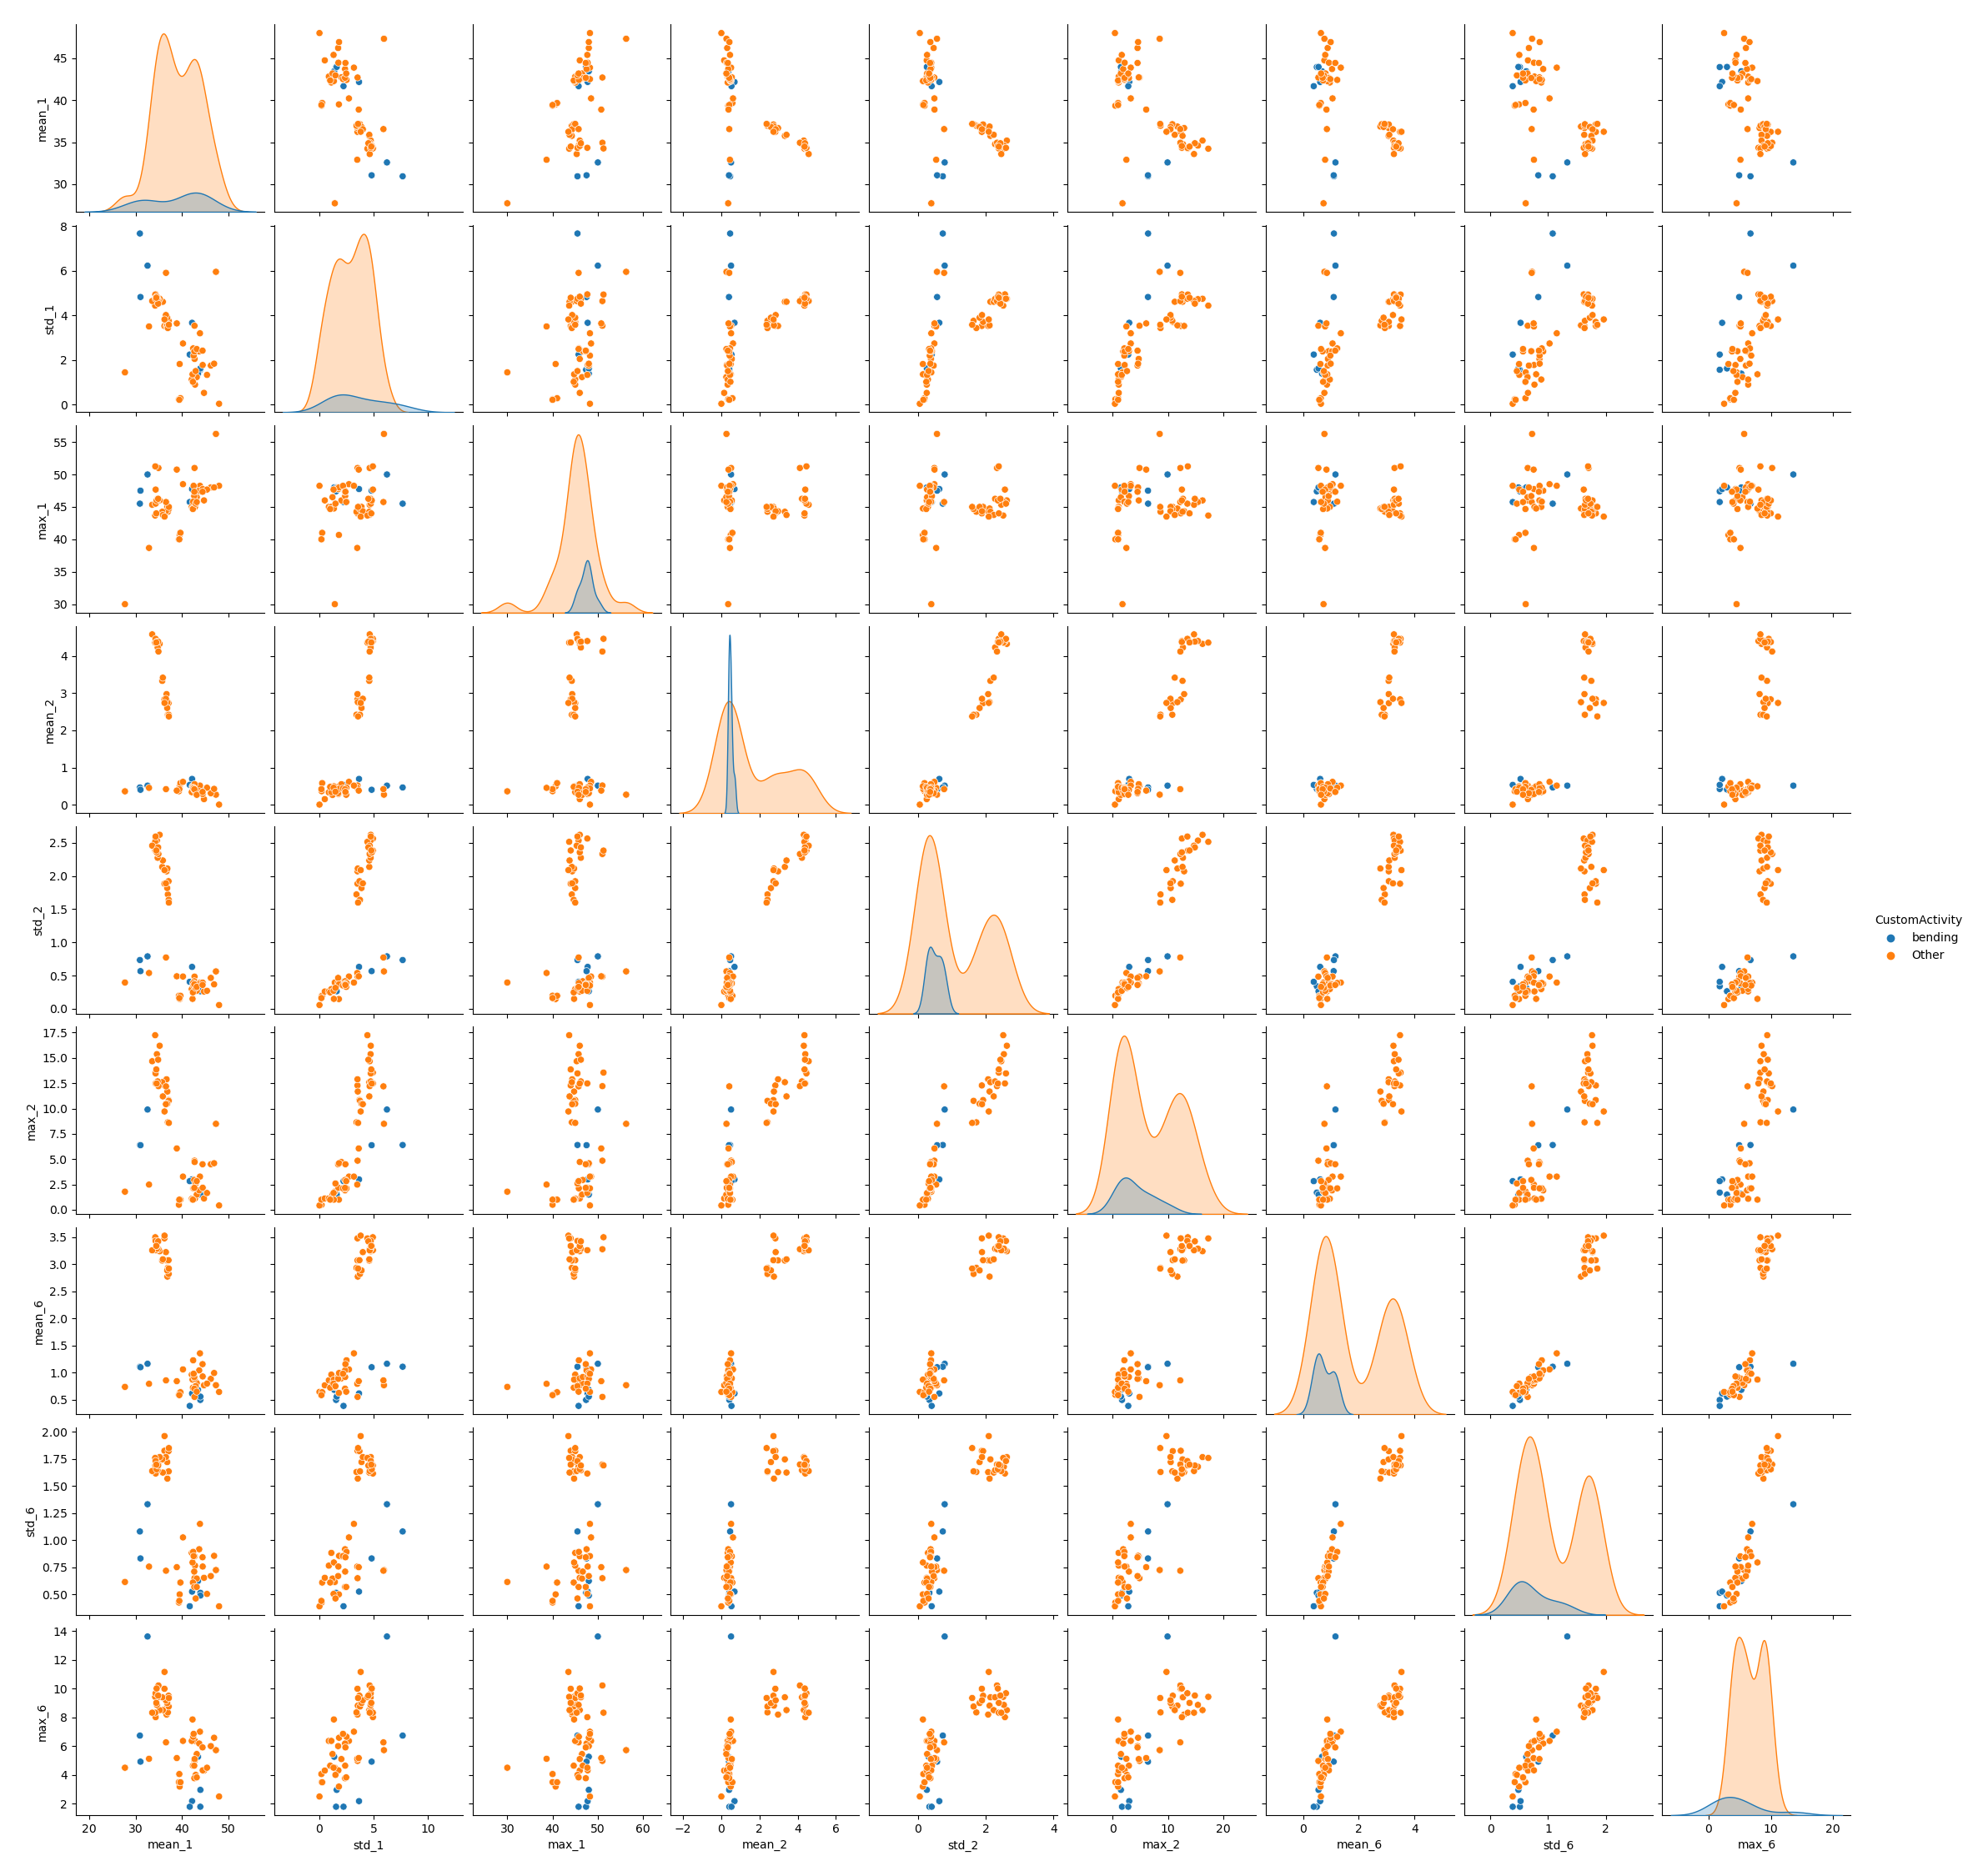

ii. Break each time series in your training set into two (approximately) equal
length time series. Now instead of 6 time series for each of the training
instances, you have 12 time series for each training instance. Repeat the
experiment in 2(a)i, i.e depict scatter plots of the features extracted from both
parts of the time series 1,2, and 6. Do you see any considerable difference in
the results with those of 2(a)i?

In [19]:
train_df_list[0]

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,activity
0,0,42.00,0.71,21.25,0.43,30.00,0.00,bending1
1,250,41.50,0.50,20.25,1.48,31.25,1.09,bending1
2,500,41.50,0.50,14.25,1.92,33.00,0.00,bending1
3,750,40.75,0.83,15.75,0.43,33.00,0.00,bending1
4,1000,40.00,0.71,20.00,2.74,32.75,0.43,bending1
...,...,...,...,...,...,...,...,...
475,118750,42.50,0.50,20.00,0.82,36.00,0.00,bending1
476,119000,42.67,0.47,21.00,0.00,36.33,0.47,bending1
477,119250,44.33,0.94,21.00,0.00,36.33,0.47,bending1
478,119500,45.25,0.43,26.75,1.79,36.00,0.00,bending1


In [18]:
train_df_list2[0]

,avg_rss12_0,avg_rss12_1,var_rss12_0,var_rss12_1,avg_rss13_0,avg_rss13_1,var_rss13_0,var_rss13_1,avg_rss23_0,avg_rss23_1,var_rss23_0,var_rss23_1,activity
0,42.00,43.33,0.71,0.94,21.25,18.00,0.43,0.00,30.00,35.67,0.00,0.47,bending1
1,41.50,44.20,0.50,0.75,20.25,19.75,1.48,0.83,31.25,35.40,1.09,1.20,bending1
2,41.50,45.00,0.50,0.00,14.25,21.75,1.92,0.83,33.00,35.00,0.00,1.41,bending1
3,40.75,45.00,0.83,0.00,15.75,23.33,0.43,0.47,33.00,36.00,0.00,0.00,bending1
4,40.00,45.00,0.71,0.00,20.00,24.00,2.74,0.00,32.75,36.00,0.43,0.00,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,45.50,42.50,0.50,0.50,24.00,20.00,0.00,0.82,36.00,36.00,0.00,0.00,bending1
236,45.25,42.67,0.43,0.47,23.25,21.00,0.83,0.00,36.00,36.33,0.00,0.47,bending1
237,45.00,44.33,0.00,0.94,20.75,21.00,1.09,0.00,36.00,36.33,0.00,0.47,bending1
238,44.25,45.25,0.83,0.43,18.00,26.75,0.00,1.79,36.00,36.00,0.00,0.00,bending1


In [9]:
def split_df(df, num):  
    # Split the dataframe within each instance
    # If split the time series into 2 parts, num = 2
    if len(df) % num == 0:
        pass
    else:
        remainder = len(df) % num
        df = df.iloc[:(-1)*remainder]   # Sacrifice the last rows of the dataframe so it has an even number of rows
        
    col_headers = []
    col_list = []
    for col_name in df.columns[1:7]:   # All time series columns
        split_col = np.array_split(df[col_name], num)   # a list of smaller arrays
        for i in range(num):
            col_headers.append(f'{col_name}_{i}')
            col_list.append(split_col[i])  # Split each columns into {num}
    df_split = pd.DataFrame({})
    for i in range(len(col_headers)):
        df_split[col_headers[i]] = col_list[i].to_numpy()
    df_split['activity'] = df['activity']   # Add the activity column for reference
    return df_split



In [10]:
# Check the splitting result
train_df_list2 = []   # Create a new dataframe that only displays the column 1, 2, 6. Split
for df in train_df_list:
    train_df_list2.append(split_df(df, 2))
train_df_list2

[     avg_rss12_0  avg_rss12_1  var_rss12_0  var_rss12_1  avg_rss13_0  \
 0          42.00        43.33         0.71         0.94        21.25   
 1          41.50        44.20         0.50         0.75        20.25   
 2          41.50        45.00         0.50         0.00        14.25   
 3          40.75        45.00         0.83         0.00        15.75   
 4          40.00        45.00         0.71         0.00        20.00   
 ..           ...          ...          ...          ...          ...   
 235        45.50        42.50         0.50         0.50        24.00   
 236        45.25        42.67         0.43         0.47        23.25   
 237        45.00        44.33         0.00         0.94        20.75   
 238        44.25        45.25         0.83         0.43        18.00   
 239        43.25        47.25         0.83         0.83        18.00   
 
      avg_rss13_1  var_rss13_0  var_rss13_1  avg_rss23_0  avg_rss23_1  \
 0          18.00         0.43         0.00      

In [11]:
# Get mean, std, max for time series (0, 1), (2, 3) and (10, 11) ('avg_rss12', 'var_rss12', 'var_rss23')
def extract_features(df_list, feature_index_list):   # Input: a list of instances dfs
    result_list = []
    for i in np.arange(len(df_list)):
        row_i_list = []
        for col in df_list[0].columns[feature_index_list]:  # Column headers (except for the "activity" column)
            cell = pd.DataFrame({
                f'mean_{col}': [np.mean(df_list[i][col])],
                f'std_{col}': [np.std(df_list[i][col])],
                f'max_{col}': [np.max(df_list[i][col])]   # indicate the stat methods here.
            })
            row_i_list.append(cell)
            
        instance_activity_df = pd.DataFrame({
            'Instance': [i+1],
            'activity': train_df_list[i]['activity'][0]
        })
        row_i = pd.concat(row_i_list, axis = 1)
        row_i = pd.concat([instance_activity_df, row_i], axis = 1)

        result_list.append(row_i)
    result = pd.concat(result_list)
    result['CustomActivity'] = result['activity'].apply(lambda x: 'bending' if x in ['bending1', 'bending2'] else 'Other')
        # for plotting
    result = result.set_index('Instance')
    return result  

In [12]:
feature_index_list2 = [0, 1, 2, 3, 10, 11]
result2 = extract_features(train_df_list2, feature_index_list2)
result2

,activity,mean_avg_rss12_0,std_avg_rss12_0,max_avg_rss12_0,mean_avg_rss12_1,std_avg_rss12_1,max_avg_rss12_1,mean_var_rss12_0,std_var_rss12_0,max_var_rss12_0,mean_var_rss12_1,std_var_rss12_1,max_var_rss12_1,mean_var_rss23_0,std_var_rss23_0,max_var_rss23_0,mean_var_rss23_1,std_var_rss23_1,max_var_rss23_1,CustomActivity
Instance,,,,,,,,,,,,,,,,,,,,
1,bending1,44.057167,1.553724,46.50,43.851833,1.553920,47.40,0.381042,0.328853,1.50,0.471458,0.341632,1.70,0.598250,0.525558,1.79,0.388333,0.477530,1.50,bending
2,bending1,43.278875,3.466111,47.75,41.080750,3.530103,46.00,0.673292,0.632962,3.00,0.718792,0.626606,2.86,0.640958,0.553385,1.53,0.586083,0.490847,2.18,bending
3,bending1,41.621208,3.112140,45.75,41.734917,0.594677,43.67,0.623083,0.488574,2.83,0.448875,0.272481,1.12,0.419083,0.410342,1.79,0.347500,0.362386,1.50,bending
4,bending1,44.117042,1.357000,48.00,42.792875,1.056584,46.50,0.250042,0.313444,1.30,0.506125,0.260217,1.58,0.815417,0.716518,5.26,0.543875,0.472458,4.06,bending
5,bending1,43.486208,1.279302,45.00,44.452042,1.767557,48.00,0.378667,0.283841,1.30,0.447583,0.235002,1.50,0.524875,0.485832,2.28,0.585750,0.486900,2.96,bending
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,walking,33.334500,4.864267,45.00,33.839250,4.402702,45.33,4.408083,2.191626,11.78,4.745042,2.688600,14.67,3.229167,1.633895,8.29,3.290292,1.642591,8.32,Other
66,walking,34.036750,4.862718,44.50,34.608750,4.611762,45.50,4.778292,2.756968,13.47,4.134375,2.382481,12.50,3.543708,1.699547,8.41,3.321417,1.754711,9.67,Other
67,walking,34.033875,4.748833,43.33,35.058583,4.870471,46.00,4.574625,2.386816,12.47,4.169292,2.311099,12.28,3.244042,1.616389,10.00,3.432208,1.687524,8.64,Other


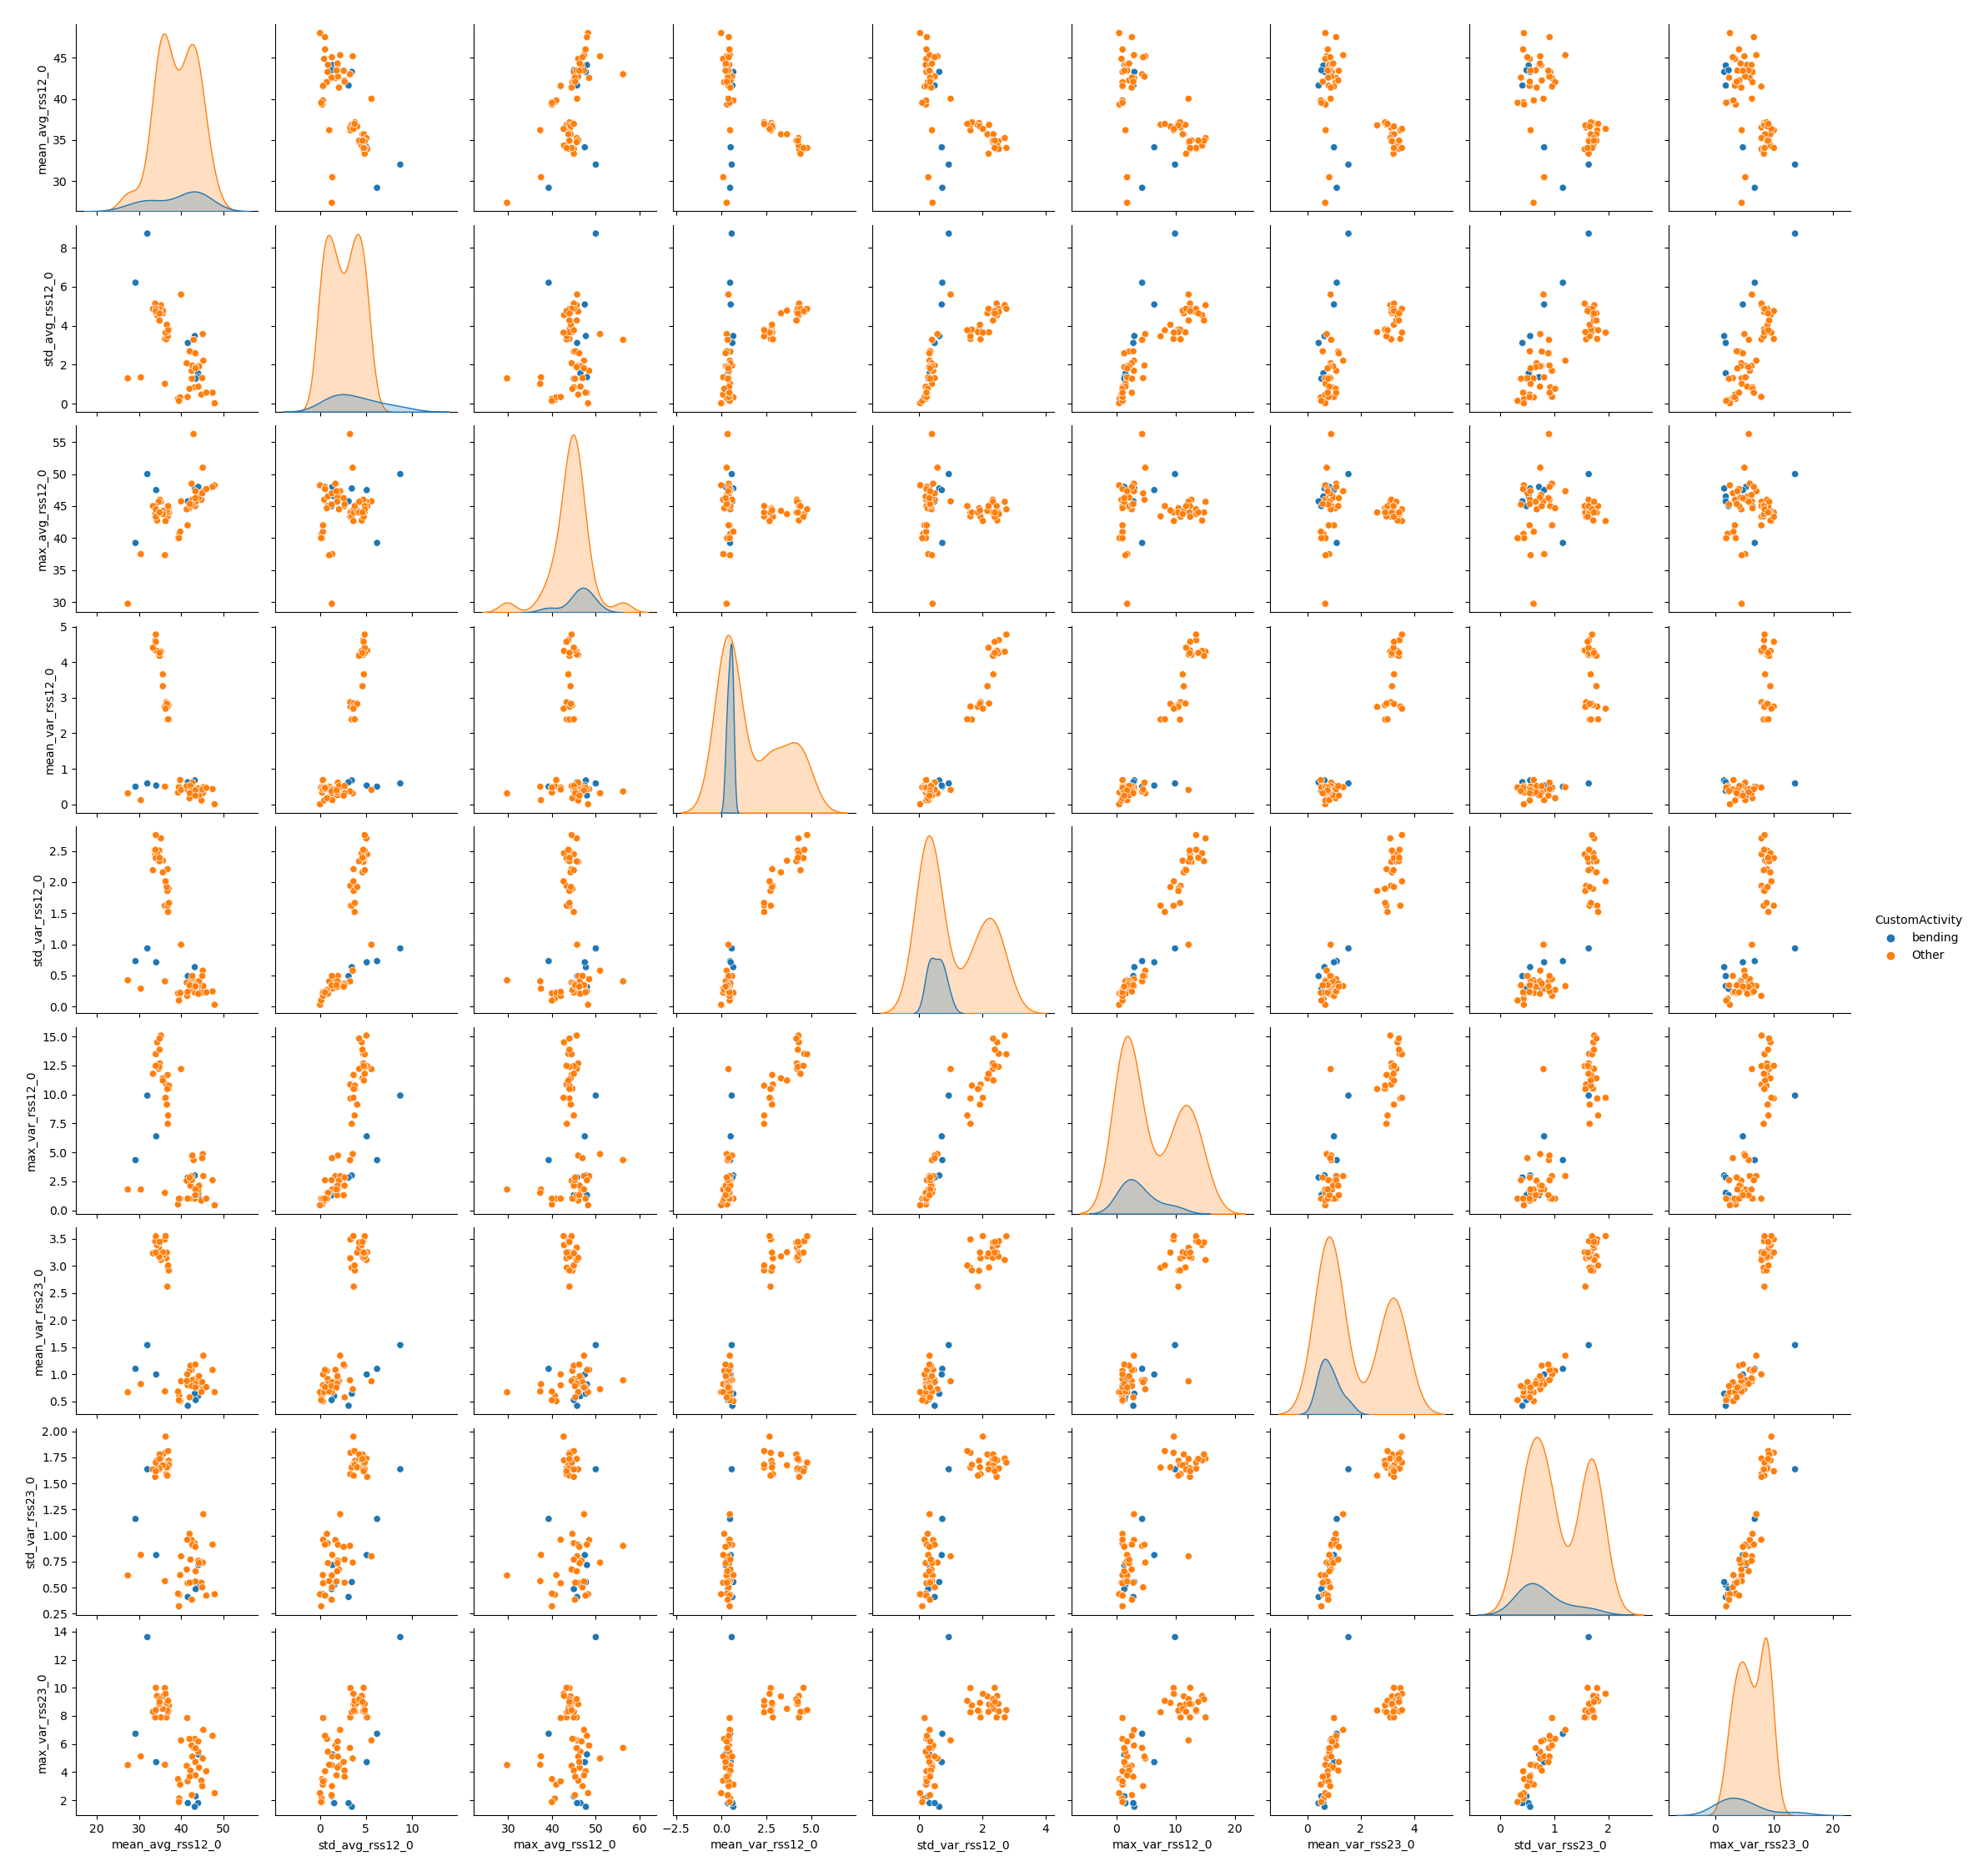

    It is hard to see any considerable difference between the scatterplots of the split and the unsplit datasets. While some interactions between variables had a better seperation between "bending" and "Other", some other interactions did the opposite. 

iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value
of l and refit a logistic regression model using your pruned set of features.
Alternatively, you can use backward selection using sklearn.feature selection
or glm in R. Use 5-fold cross-validation to determine the best value of the pair
(l, p), where p is the number of features used in recursive feature elimination.
Explain what the right way and the wrong way are to perform cross-validation
in this problem. Obviously, use the right way! Also, you may encounter the
problem of class imbalance, which may make some of your folds not having
any instances of the rare class. In such a case, you can use stratified cross
validation. Research what it means and use it if needed.

In [17]:
train_df_list2[0]

,avg_rss12_0,avg_rss12_1,var_rss12_0,var_rss12_1,avg_rss13_0,avg_rss13_1,var_rss13_0,var_rss13_1,avg_rss23_0,avg_rss23_1,var_rss23_0,var_rss23_1,activity
0,42.00,43.33,0.71,0.94,21.25,18.00,0.43,0.00,30.00,35.67,0.00,0.47,bending1
1,41.50,44.20,0.50,0.75,20.25,19.75,1.48,0.83,31.25,35.40,1.09,1.20,bending1
2,41.50,45.00,0.50,0.00,14.25,21.75,1.92,0.83,33.00,35.00,0.00,1.41,bending1
3,40.75,45.00,0.83,0.00,15.75,23.33,0.43,0.47,33.00,36.00,0.00,0.00,bending1
4,40.00,45.00,0.71,0.00,20.00,24.00,2.74,0.00,32.75,36.00,0.43,0.00,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,45.50,42.50,0.50,0.50,24.00,20.00,0.00,0.82,36.00,36.00,0.00,0.00,bending1
236,45.25,42.67,0.43,0.47,23.25,21.00,0.83,0.00,36.00,36.33,0.00,0.47,bending1
237,45.00,44.33,0.00,0.94,20.75,21.00,1.09,0.00,36.00,36.33,0.00,0.47,bending1
238,44.25,45.25,0.83,0.43,18.00,26.75,0.00,1.79,36.00,36.00,0.00,0.00,bending1


In [13]:
# 2(a) iii.
# Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length 
# Split and tidy the dataset before training
def split_and_tidy(df_list, l):
    df_list2 = []   # Create a new dataframe based on number of split time series
    for d in df_list:
        df_list2.append(split_df(d, l))
    df = pd.concat(df_list2)
    
    # Make "activity" into binary
    df['Bending'] = df['activity'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)
    df = df.drop('activity', axis='columns')
    
    # Impute to get rid of missing values
    # Reference: simple imputer by GeeksforGeeks.org: https://www.geeksforgeeks.org/ml-handle-missing-data-with-simple-imputer/
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df

In [14]:
# RFE and CV (5 folds)
# RFE Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
def logit_rfe_cv(df_train_list, l):
    # Tidy the data
    df_train = split_and_tidy(df_train_list, l)
    
    X_train = df_train.iloc[:,:-1]
    y_train = df_train['Bending']
    
    #model = LogisticRegression(C = 99999, max_iter = 100)  # large C to remove penalty. Set max_iter to prevent instablility
    model =  LogisticRegression(penalty='none', max_iter=100)   # Set max_iter to prevent instablility

    # RFECV reference: https://www.geeksforgeeks.org/recursive-feature-elimination-with-cross-validation-in-scikit-learn/ and ChatGPT
    cv = StratifiedKFold(n_splits = 5)   # 5 folds CV (stratified CV to mitigate class imblance)
    rfecv = RFECV(estimator = model, step = 1, cv = cv, scoring = 'accuracy')
    rfecv.fit(X_train, y_train)

    # Find the cross-validation score
    # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
    scores = cross_val_score(rfecv, X_train, y_train, cv=cv, scoring='accuracy')

    # Summarize the selection of the attributes
    ranking = rfecv.ranking_
    support = rfecv.support_
    selected_features = (df_train.columns[:-1][support]).to_numpy()
    return selected_features, ranking, scores

In [15]:
# Output each (l,p) pairs
l_list = np.arange(1, 21, 1)
p_list = []
score_list = []
predictors_list = []
for l in l_list:
    feats, rank, scores = logit_rfe_cv(train_df_list, l)
    p = len(feats)
    score = np.mean(scores)
    p_list.append(p)
    score_list.append(score)
    predictors_list.append(feats)
    print(f'l = {l}, p = {p}, Mean CV accuracy score = {score:.3f}, \n    features: {feats}')
    print('')
    #print(f'Selected_features: {feats}')
    #print(f"Ranking: {rank}")

l = 1, p = 4, Mean CV accuracy score = 0.898, 
    features: ['avg_rss12_0' 'var_rss12_0' 'var_rss13_0' 'avg_rss23_0']

l = 2, p = 4, Mean CV accuracy score = 0.906, 
    features: ['var_rss12_0' 'var_rss12_1' 'var_rss13_1' 'avg_rss23_0']



KeyboardInterrupt: 

In [ ]:
# Obtain the best values
best_score = max(score_list)
best_score_index = score_list.index(best_score)
best_l = l_list[best_score_index]
best_p = p_list[best_score_index]
best_predictors = predictors_list[best_score_index]

# Put it in a table
print('\n The best combination of l and p (with the highest CV accuracy score)')
output = pd.DataFrame({
    "l": [best_l],
    'p': [best_p],
    "Accuracy Score": [best_score]
})
print(output[output['Accuracy Score'] == best_score])

    output:
     The best combination of l and p (with the highest CV accuracy score)
        l  p  Accuracy Score
    0  18  9        0.956515

    features: ['avg_rss12_10' 'avg_rss12_12' 'var_rss12_10' 'var_rss13_9' 'var_rss13_10' 'avg_rss23_0' 'avg_rss23_1' 'var_rss23_10' 'var_rss23_12']

Explain what the right way and the wrong way are to perform cross-validation in this problem

    The right way to do Cross Validation is to do RFE feature selection and cross validate them at the same time for each l. The wrong way is to select all the features for all the l's and do cross validation for all of them afterward. 

iv. Report the confusion matrix and show the ROC and AUC for your classifier
on train data. Report the parameters of your logistic regression βi
’s as well
as the p-values associated with them.

In [ ]:
# iv.
# Use the best l and selected predictors to make an ROC curve and find AUC
# Tidy the data
df_train = split_and_tidy(train_df_list, best_l)

X_train = df_train[best_predictors]
y_train = df_train['Bending']
X_train = sm.add_constant(X_train)  # Add intercept to the model

# Fit the logistic regression model using Statsmodels
log_sm_model = sm.Logit(y_train, X_train).fit()
print(log_sm_model.summary())

# Fit the logistic regression model using sklearn for ROC and AUC
log_sk_model = LogisticRegression(penalty='none', max_iter=100)
log_sk_model.fit(X_train, y_train)

# Predict
y_train_pred = log_sk_model.predict(X_train)

# Confusion Matrix  ([[TP, FP], [FN, TN]])
print('\nConfusion Matrix:')
print(confusion_matrix(y_train, y_train_pred))
print('')

# Calculate ROC curve
# Reference: https://www.geeksforgeeks.org/how-to-plot-roc-curve-in-python/
# Reference: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
y_prob = log_sk_model.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_prob)
# Calculate AUC  Reference: https://www.rasgoml.com/feature-engineering-tutorials/how-to-calculate-auc-with-scikit-learn
auc = roc_auc_score(y_train, y_prob)
print("AUC:", auc)

# Plot ROC curve, Assisted by ChatGPT
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

v. Test the classifier on the test set. Remember to break the time series in
your test set into the same number of time series into which you broke your
training set. Remember that the classifier has to be tested using the features
extracted from the test set. Compare the accuracy on the test set with the
cross-validation accuracy you obtained previously.

In [ ]:
# We obtained the best l and p for to get the best Train CV accuracy

# Tidy the data
df_train = split_and_tidy(train_df_list, best_l) 
df_test = split_and_tidy(test_df_list, best_l)

X_train = df_train[best_predictors] 
y_train = df_train['Bending']
X_test = df_test[best_predictors]
y_test = df_test['Bending']

log_model = LogisticRegression(penalty = 'none', max_iter = 100)  # large C to remove penalty. Set max_iter to prevent instablility
log_model.fit(X_train, y_train)

# Make prediction and evalutaion
y_test_pred = log_model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)

print('Test accuracy:', accuracy)

    The test accuracy (0.933) is slightly lower than the train accuracy (0.956), as expected. Overall, a pretty good prediction (however, due to class imbalance, the accuracy may be inflated)

vi. Do your classes seem to be well-separated to cause instability in calculating
logistic regression parameters?

    Yes, the classes seem to be well-seperated to cause instability in calculating logistic regression parameters. To counter this, I had to put a limit on maximum iterations of the logistic model to prevent instability. 

vii. From the confusion matrices you obtained, do you see imbalanced classes?
If yes, build a logistic regression model based on case-control sampling and
adjust its parameters. Report the confusion matrix, ROC, and AUC of the
model.

    Yes, there exists some class imbalance. There are many more cases for the non-bending class than the bending class. Therefore, we conduct case-control sampling (downsampling specifically) to make 50-50 of both "Bending" and "Other"

In [ ]:
# Case-controled logistic modeling

# Referenced from ChatGPT
cases = df_train[df_train['Bending'] == 1]
controls = df_train[df_train['Bending'] == 0]

# Case-control sampling (down sampling)
sample_size = min(len(cases), len(controls))
sampled_cases = cases.sample(n = sample_size, random_state = 2024)
sampled_controls = controls.sample(n = sample_size, random_state = 2024)

sampled_df = pd.concat([sampled_cases, sampled_controls])
X_train = sampled_df[best_predictors]
y_train = sampled_df['Bending']
X_test = df_test[best_predictors]
y_test = df_test['Bending']

log_model = LogisticRegression(penalty = 'none', max_iter = 100)
log_model.fit(X_train, y_train)

# Make prediction and evalutaion
y_test_pred = log_model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)

print('Test accuracy after down sampling to mitigate class imbalance:\n', accuracy)
print('')

# Confusion Matrix  ([[TP, FP], [FN, TN]])
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))
print('')

# Calculate ROC curve
y_prob = log_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# Calculate AUC
auc = roc_auc_score(y_test, y_prob)
print("AUC:", auc)

# Plot ROC curve
# Assisted by ChatGPT
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### (b) Binary Classification Using L1-penalized logistic regression

i. Repeat 2(a)iii using L1-penalized logistic regression,8
i.e. instead of using pvalues for variable selection, use L1 regularization. Note that in this problem,
you have to cross-validate for both l, the number of time series into which you
break each of your instances, and λ, the weight of L1 penalty in your logistic
regression objective function (or C, the budget). Packages usually perform
cross-validation for λ automatically

In [ ]:
# 2(b) i.
def logit_L1(df_train_list, df_test_list, l):   # using LogisticRegressionCV
    # Tidy the data
    df_train = split_and_tidy(df_train_list, l)
    df_test = split_and_tidy(df_test_list, l)
    
    X_train = df_train.iloc[:,:-1]
    y_train = df_train['Bending']
    X_test = df_test.iloc[:,:-1]
    y_test = df_test['Bending']

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
    logistic_cv = LogisticRegressionCV(Cs = 10, cv = StratifiedKFold(n_splits = 5), penalty = 'l1', solver = 'liblinear', random_state = 2024)
    logistic_cv.fit(X_train, y_train)

    # Get the best lambda
    best_lambda = logistic_cv.C_[0]

    # Predict on the test set
    y_pred = logistic_cv.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    #print("Classification Report:")
    #print(classification_report(y_test, y_pred))
    return best_lambda, accuracy

In [ ]:
# Output each (l,p) pairs
l_list = np.arange(1, 21, 1)
lambda_list = []
score_list = []
for l in l_list:
    best_lambda, accuracy = logit_L1(train_df_list, test_df_list, l)
    print(f'For l = {l},  Best λ: {best_lambda},  Accuracy Score: {accuracy:.3f}')
    lambda_list.append(best_lambda)
    score_list.append(accuracy)

# Find the best l and lambda combination:
best_score = max(score_list)
best_score_index = score_list.index(best_score)
best_l = l_list[best_score_index]
best_lam = lambda_list[best_score_index]

# Put it in a table
print('\n The best combination of l and λ')
output = pd.DataFrame({
    "l": [best_l],
    'Best λ': [best_lam],
    "Accuracy Score": [best_score]
})
print(output[output['Accuracy Score'] == best_score])

ii. Compare the L1-penalized with variable selection using p-values. Which one
performs better? Which one is easier to implement?

    L1 penalization is easier to implement, and it takes less time to run too. 

### (c) Multi-class Classification (The Realistic Case)

i. Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [ ]:
# 2(c) i.
def split_and_tidy_full(df_list, l):   # Split each instance into l parts but keep the original "activity"
    df_list2 = []   # Create a new dataframe based on number of split time series
    for d in df_list:
        df_list2.append(split_df(d, l))
    df = pd.concat(df_list2)

    # Make "bending1" and "bending2" into "bending"
    df['activity'] = df['activity'].apply(lambda x: 'bending' if x in ['bending1', 'bending2'] else x)
    
    # Remove missing values (if any)
    df_cleaned = df.dropna()
    return df_cleaned

#split_and_tidy_full(train_df_list, 2).sample(7)

In [ ]:
def multi_logic_L1(df_train_list, df_test_list, l):
    df_train = split_and_tidy_full(df_train_list, l)
    df_test = split_and_tidy_full(df_test_list, l)

    X_train = df_train.iloc[:,:-1]
    y_train = df_train['activity']
    X_test = df_test.iloc[:,:-1]
    y_test = df_test['activity']
    
    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Reference: https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    multi_logit_cv = LogisticRegressionCV(Cs = 10, cv = StratifiedKFold(n_splits = 5), penalty = 'l1', solver = 'liblinear', multi_class = 'ovr', max_iter = 100, random_state = 2024)
    multi_logit_cv.fit(X_train, y_train)

    # Get the best lambda
    best_lambda = multi_logit_cv.C_[0]

    # Predict on the test set
    y_pred = multi_logit_cv.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    return best_lambda, accuracy

In [ ]:
# Output each (l,p) pairs
l_list = np.arange(1, 21, 1)
lambda_list = []
score_list = []
for l in l_list:
    best_lambda, accuracy = multi_logic_L1(train_df_list, test_df_list, l)
    print(f'For l = {l},  Best λ: {best_lambda},  Accuracy Score: {accuracy:.3f}')
    lambda_list.append(best_lambda)
    score_list.append(accuracy)

# Find the best l and lambda combination:
best_score = max(score_list)
best_score_index = score_list.index(best_score)
best_l = l_list[best_score_index]
best_lam = lambda_list[best_score_index]

# Put it in a table
print('\n The best combination of l and p (with the highest CV accuracy score)')
output = pd.DataFrame({
    "l": [best_l],
    'Best λ': [best_lam],
    "Accuracy Score": [best_score]
})
output[output['Accuracy Score'] == best_score]

    We reached our best test error at l = 13, with test error rate being 27.5% (1 - 0.725 = 0.275). 

ii. Repeat 2(c)i using a Na¨ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

In [ ]:
# 2c ii.
def Naive_Bayes(df_train_list, df_test_list, l):
    # Clean up the data
    df_train = split_and_tidy_full(df_train_list, l)
    df_test = split_and_tidy_full(df_test_list, l)

    X_train = df_train.iloc[:,:-1]
    y_train = df_train['activity']
    X_test = df_test.iloc[:,:-1]
    y_test = df_test['activity']

    """
    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    """
    # Standardization creates negative values which Multinomial model doesn't take too well.
    
    # Gaussian  (Reference: https://www.geeksforgeeks.org/naive-bayes-classifiers/)
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    gnb_y_pred = gnb.predict(X_test)
    gnb_accuracy = accuracy_score(y_test, gnb_y_pred)

    # Multinomial  (Reference: https://www.geeksforgeeks.org/multinomial-naive-bayes/)
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    mnb_y_pred = mnb.predict(X_test)
    mnb_accuracy = accuracy_score(y_test, mnb_y_pred)
    
    return gnb_accuracy, mnb_accuracy

In [ ]:
# Output the best accuracy
l_list = np.arange(1, 21, 1)
gnb_accuracy_list = []
mnb_accuracy_list = []
for l in l_list:
    gnb_acc, mnb_acc = Naive_Bayes(train_df_list, test_df_list, l)
    gnb_accuracy_list.append(gnb_acc)
    mnb_accuracy_list.append(mnb_acc)
    print(f'For l = {l},  Gaussian Accuracy: {gnb_acc:.3f},  Multinomial Accuracy: {mnb_acc:.3f}')

# Find the best accuracy for both methods
best_gnb_acc = max(gnb_accuracy_list)
best_mnb_acc = max(mnb_accuracy_list)
print("\nBest Naive Bayes Gaussian accuracy: ", best_gnb_acc, "  where l =", l_list[gnb_accuracy_list.index(best_gnb_acc)])
print("\nBest Naive Bayes Multinomial accuracy: ", best_mnb_acc, "  where l =", l_list[mnb_accuracy_list.index(best_mnb_acc)])

iii. Which method is better for multi-class classification in this problem?

    Judging from the accuracy score, the multiclass classification with Naive Bayes Multinomial is a better method, with 86.4% accuracy rate.  

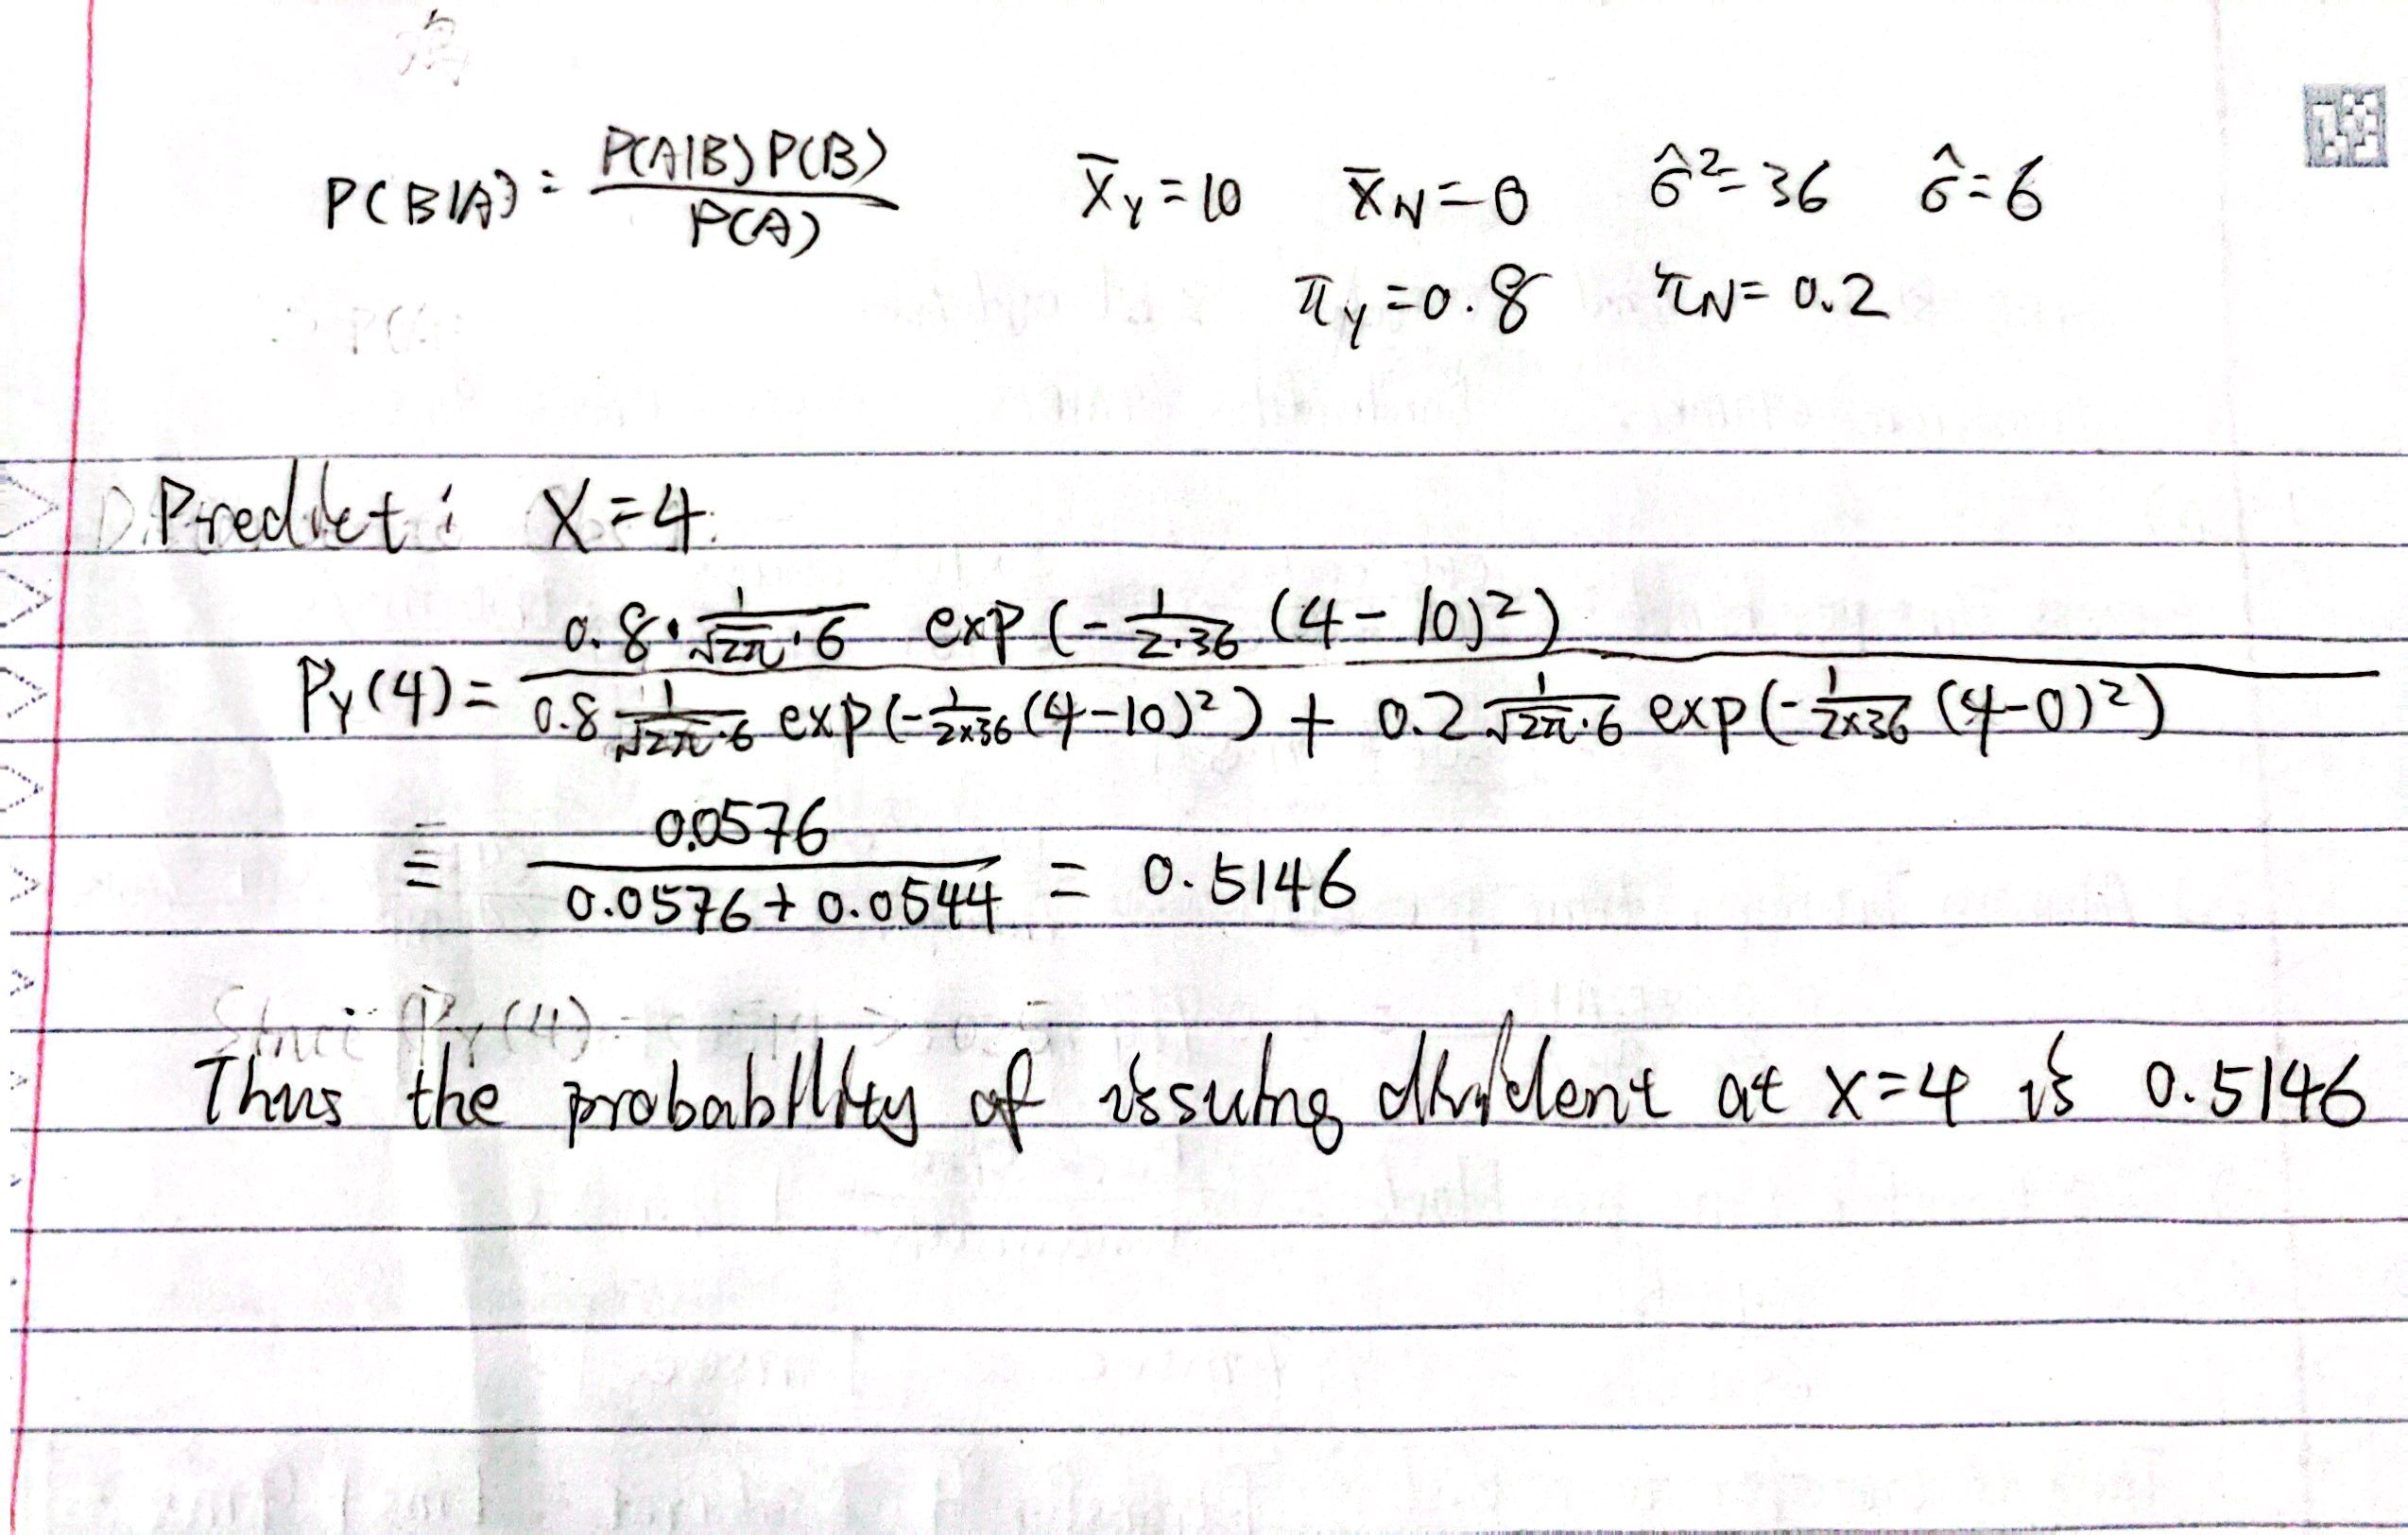

## Reference:
* Stop printing warning from sklearn and pandas from Stackoverflow: 
https://stackoverflow.com/questions/32612180/eliminating-warnings-from-scikit-learn

* Time domain features on StackExchange: 
https://stats.stackexchange.com/questions/50807/features-for-time-series-classification

* Bootstrapping by Statology.org: https://www.statology.org/bootstrapping-in-python/

* Imputer, ROC, CV, NB by GeeksforGeeks.org: 
https://www.geeksforgeeks.org/ml-handle-missing-data-with-simple-imputer/
https://www.geeksforgeeks.org/how-to-plot-roc-curve-in-python/
https://www.geeksforgeeks.org/recursive-feature-elimination-with-cross-validation-in-scikit-learn/
https://www.geeksforgeeks.org/naive-bayes-classifiers/
https://www.geeksforgeeks.org/multinomial-naive-bayes/

* sklearn package documentations:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


* ROC curve and Multinomial regression from machinelearningmastery.com:
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
https://machinelearningmastery.com/multinomial-logistic-regression-with-python/


* Calculating AUC from rasgoml.com: 
https://www.rasgoml.com/feature-engineering-tutorials/how-to-calculate-auc-with-scikit-learn
